In [0]:
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()

from keras.datasets import mnist
from tensorflow.python.keras import *
from tensorflow.python.keras.layers import *

from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.compat.v1.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
data=mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
x_train,y_train,x_test,y_test=data[0][0],data[0][1],data[1][0],data[1][1]

In [0]:
X_train=(x_train.astype('float32')-127.5)/127.5

In [0]:
print(X_train.dtype)

float32


In [0]:
#Noise Dim
NOISE_DIM=100
adam=Adam(lr=2e-4,beta_1=0.5) 

#Generator
generator=Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))

# UPsampling(14,14,128) + Convolution(14,14,64)
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(BatchNormalization())

# UPsampling(28,28,64) + Convolution(28,28,1)
generator.add(UpSampling2D())
generator.add(Conv2D(1,kernel_size=(5,5),padding='same',activation="tanh"))

generator.compile(loss="binary_crossentropy",optimizer=adam)
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 28, 64)       

In [0]:
discriminator=Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),input_shape=(28,28,1),padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss="binary_crossentropy",optimizer=adam)
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [0]:
# GAN Model
discriminator.trainable=False

gan_input  = Input(shape=(NOISE_DIM,))
fake_img   = generator(gan_input)
gan_output = discriminator(fake_img)

model=Model(gan_input,gan_output)
model.compile(loss="binary_crossentropy",optimizer=adam)
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         840193    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 1,053,058
Trainable params: 840,065
Non-trainable params: 212,993
_________________________________________________________________


In [0]:
discriminator.compile(loss="binary_crossentropy",optimizer=adam)
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


0 D Loss 200.283928 G loss 161.224845


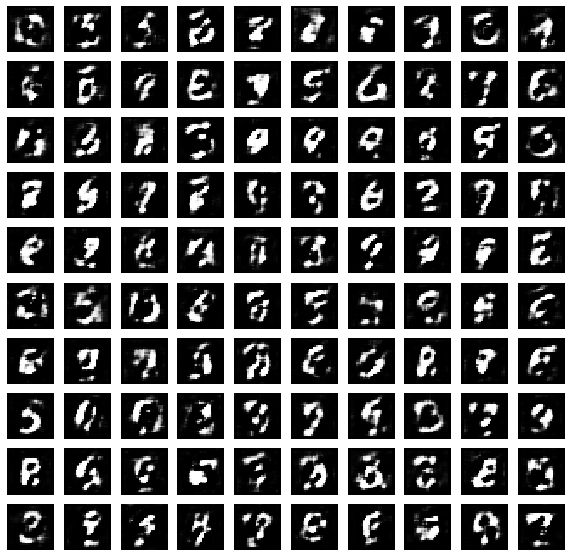

1 D Loss 325.138671 G loss 407.172008


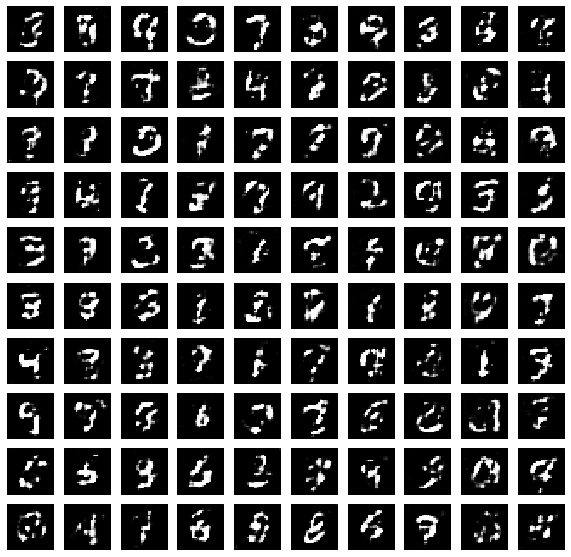

2 D Loss 315.558291 G loss 416.263093


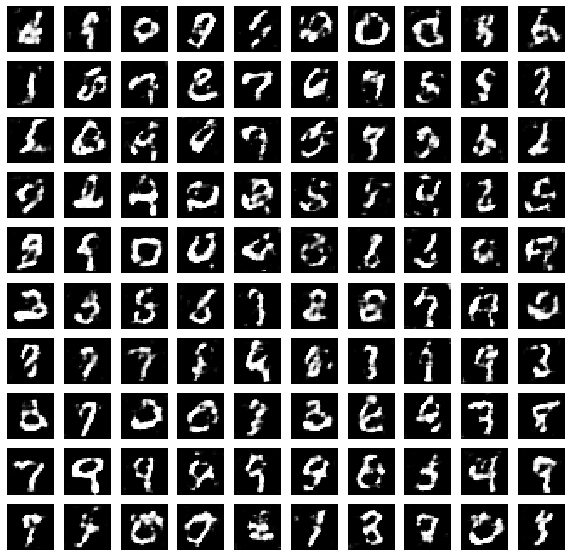

3 D Loss 316.115465 G loss 415.046566


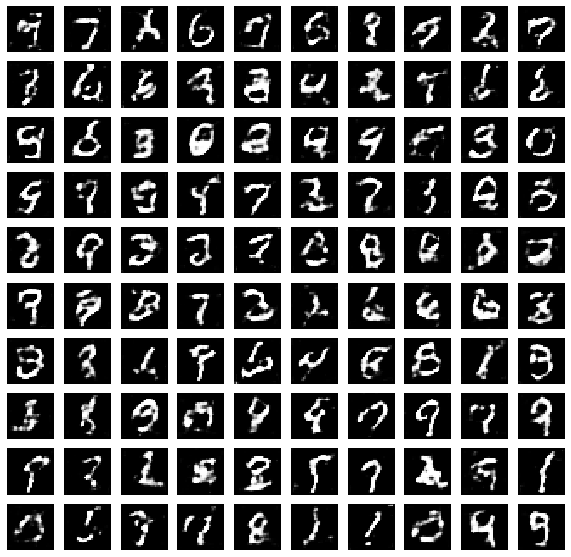

4 D Loss 315.298374 G loss 415.588286


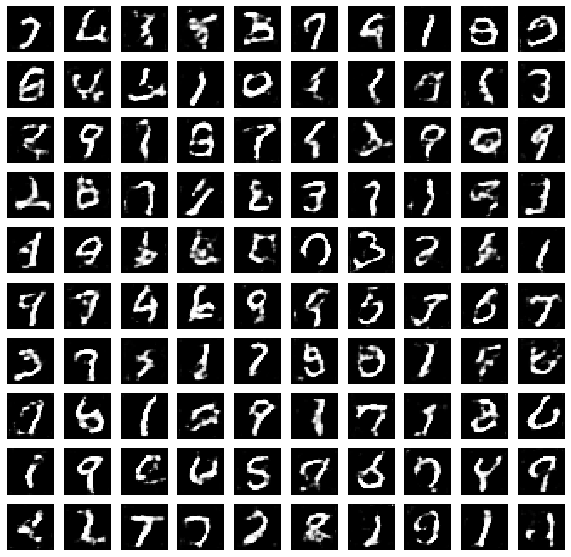

5 D Loss 313.500726 G loss 419.238140


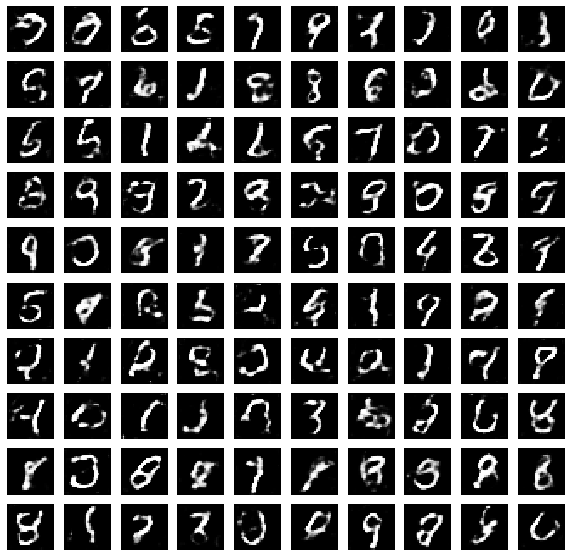

6 D Loss 310.575488 G loss 426.866611


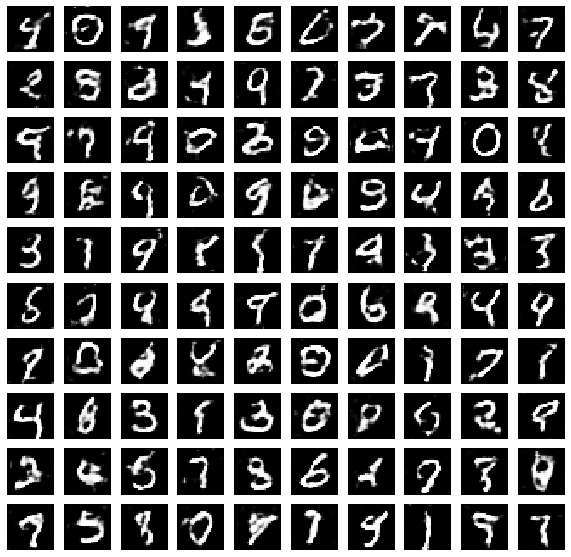

7 D Loss 306.596835 G loss 439.044502


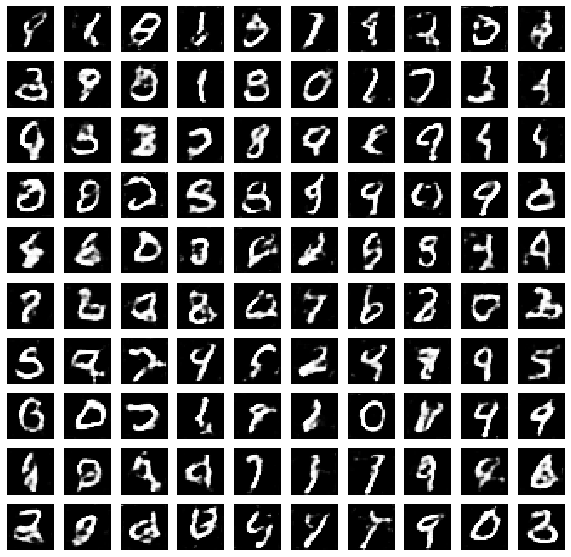

8 D Loss 301.055192 G loss 456.565561


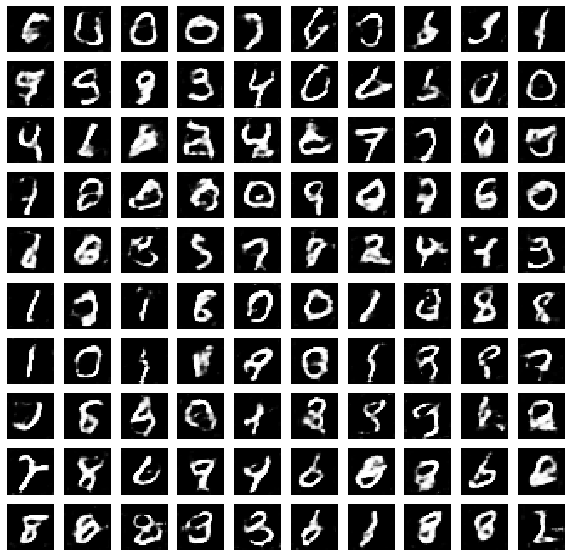

9 D Loss 295.602477 G loss 472.332600


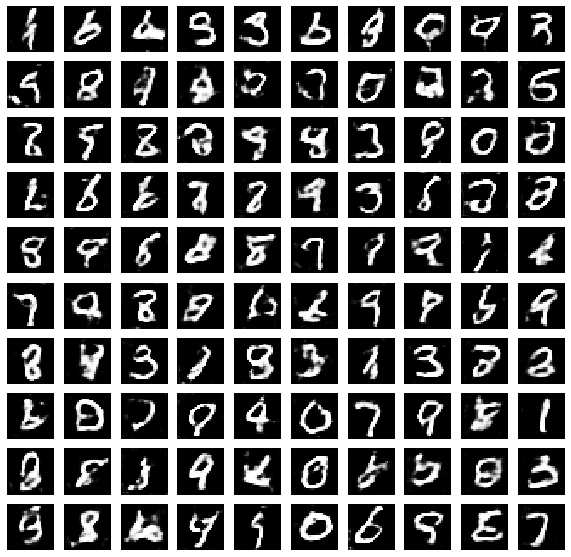

10 D Loss 288.969710 G loss 493.395507


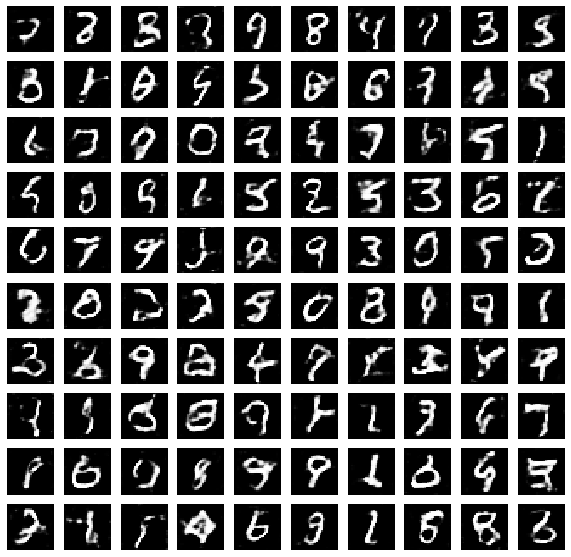

11 D Loss 281.957175 G loss 521.448357


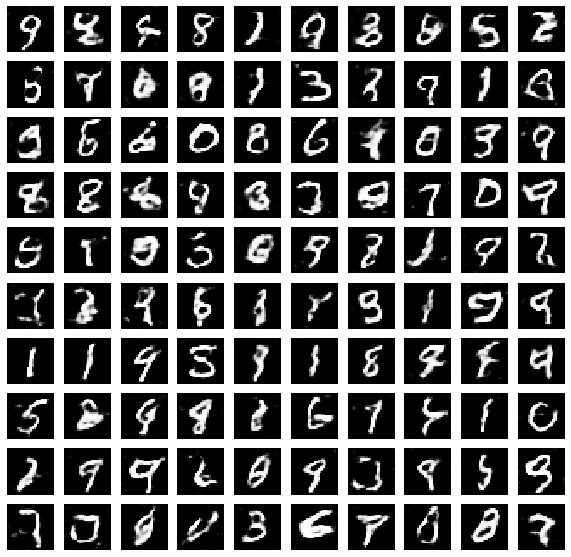

12 D Loss 274.544568 G loss 548.140746


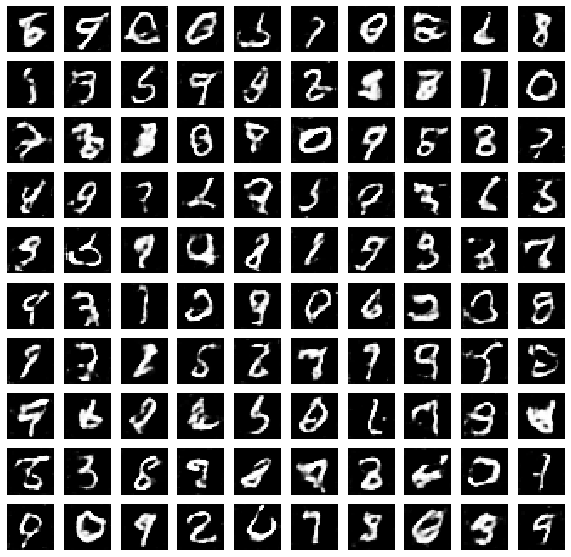

13 D Loss 267.048243 G loss 580.608352


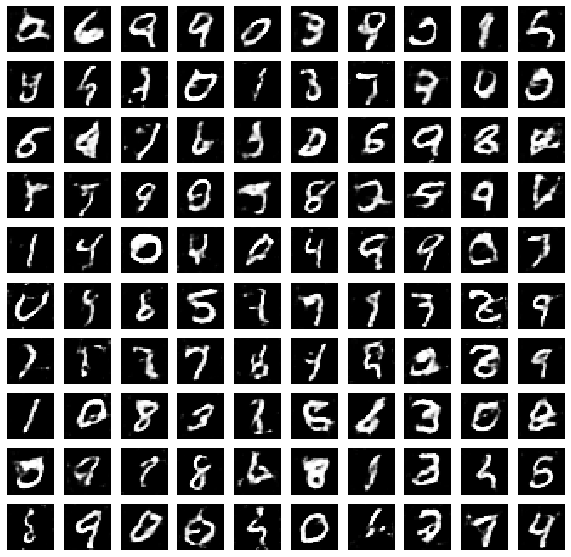

14 D Loss 259.454439 G loss 615.385861


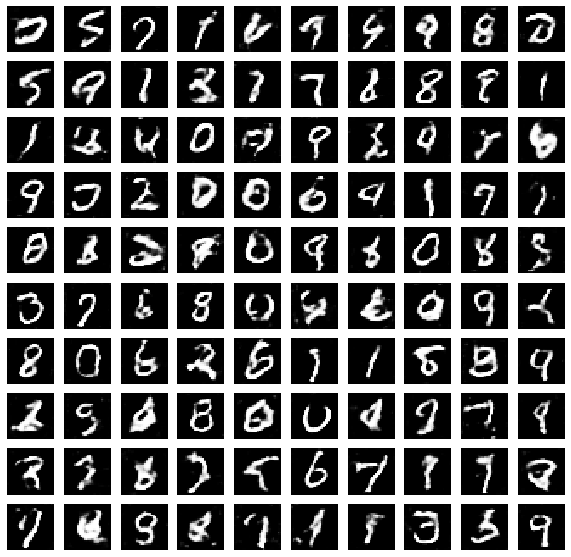

In [0]:
TOTAL_EPOCHS=15
BATCH_SIZE=256
HALF_BATCH=128

No_of_Batches=int(X_train.shape[0]/HALF_BATCH)

def show_image(epoch):
  noise=np.random.normal(0,1,size=(100,NOISE_DIM))
  fake_imgs=generator.predict(noise)*127.5+127.5
  fake_imgs=fake_imgs.reshape((100,28,28))

  plt.figure(figsize=(10,10))
  for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(fake_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.show()


for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss=0.0
  epoch_g_loss=0.0

  for step in range(No_of_Batches):
    #50% real images
    idx=np.random.randint(0,X_train.shape[0],HALF_BATCH)
    real_images=X_train[idx].reshape((*X_train[idx].shape,1))

    #50% fake images
    noise=np.random.normal(0,1,(HALF_BATCH,NOISE_DIM))
    fake_images=generator.predict(noise)

    # Data for the Discriminator 
    real_y=np.ones((HALF_BATCH,1))*.9
    fake_y=np.zeros((HALF_BATCH,1 ))

    d_loss_real = discriminator.train_on_batch(real_images,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images,fake_y)

    d_loss=0.5*d_loss_fake+0.5*d_loss_real
    epoch_d_loss+=d_loss


    noise=np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    real_y=np.ones((BATCH_SIZE,1))
    g_loss=model.train_on_batch(noise,real_y)
    epoch_g_loss+=  g_loss

  print("%d D Loss %f G loss %f"%((epoch,epoch_d_loss,epoch_g_loss)))

  if(epoch%1==0):
    show_image(epoch)

     



In [0]:
generator=Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))

# UPsampling(14,14,128) + Convolution(14,14,64)
generator.add(Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same')) 
generator.add(BatchNormalization())

# UPsampling(28,28,64) + Convolution(28,28,1)
generator.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same')) 

generator.compile(loss="binary_crossentropy",optimizer=adam)
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,193
Trainable params: 840,065
Non-trainable params: 128
______________________________________________

In [0]:
TOTAL_EPOCHS=15
BATCH_SIZE=256
HALF_BATCH=128

No_of_Batches=int(X_train.shape[0]/HALF_BATCH)

def show_image(epoch):
  noise=np.random.normal(0,1,size=(100,NOISE_DIM))
  fake_imgs=generator.predict(noise)*127.5+127.5
  fake_imgs=fake_imgs.reshape((100,28,28))

  plt.figure(figsize=(10,10))
  for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(fake_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.show()


for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss=0.0
  epoch_g_loss=0.0

  for step in range(No_of_Batches):
    #50% real images
    idx=np.random.randint(0,X_train.shape[0],HALF_BATCH)
    real_images=X_train[idx].reshape((*X_train[idx].shape,1))

    #50% fake images
    noise=np.random.normal(0,1,(HALF_BATCH,NOISE_DIM))
    fake_images=generator.predict(noise)

    # Data for the Discriminator 
    real_y=np.ones((HALF_BATCH,1))*.9
    fake_y=np.zeros((HALF_BATCH,1 ))

    d_loss_real = discriminator.train_on_batch(real_images,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images,fake_y)

    d_loss=0.5*d_loss_fake+0.5*d_loss_real
    epoch_d_loss+=d_loss


    noise=np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    real_y=np.ones((BATCH_SIZE,1))
    g_loss=model.train_on_batch(noise,real_y)
    epoch_g_loss+=  g_loss

  print("%d D Loss %f G loss %f"%((epoch,epoch_d_loss,epoch_g_loss)))

  if(epoch%1==0):
    show_image(epoch)


# MODE collapse
If the generator starts producing the same output (or a small set of outputs) over and over again, the discriminator's best strategy is to learn to always reject that output. But if the next generation of discriminator gets stuck in a local minimum and doesn't find the best strategy, then it's too easy for the next generator iteration to find the most plausible output for the current discriminator.

Each iteration of generator over-optimizes for a particular discriminator, and the discriminator never manages to learn its way out of the trap. As a result the generators rotate through a small set of output types. This form of GAN failure is called mode collapse.
